## McGill University Admission Profile

This project aims to give an overview of the admission profile of McGill University from 2015 to 2022.

Data Source: [McGill Admission Profile 2015-2022](https://www.mcgill.ca/es/admissions-profile)

Citation for guidance:

1. OpenAI. (n.d.). ChatGPT (Version 3.5) [Computer software]. Retrieved Month Day, Year, from https://www.openai.com/chatgpt

2. Matplotlib Development Team. (n.d.). Matplotlib. Retrieved Month Day, Year, from https://matplotlib.org/

3. Michael Waskom et al. (2020). Seaborn: statistical data visualization. Retrieved Month Day, Year, from https://seaborn.pydata.org/


## Import Libraries

In [1]:
# Standard imports
import pandas as pd
import numpy as np

# For web scraping
import requests
import urllib.request
from bs4 import BeautifulSoup

# For performing regex operations
import re

# For visualization
import seaborn as sns
import matplotlib.pyplot as plt



c:\ProgramData\Anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Step One: Raw Data Gathering

The data is spreaded in different websites based on admission year. It is always in the structure:
$$https://www.mcgill.ca/es/admissions-profile/fall-{Year}$$

A function for data scraping is therefore imporatant to automatize the procedure. Thus, it requires all the websites passed in possessing the same sturcture. The function `get_table()` will be used.

However, the website structure is always changing so there will be incidences where the function is not applicable. In this case, case by case scraping is needed.

For the purpose of the project, the data from **2015-2021** will be used as they are in the standard structure. 

At the same time, it is also important to concatenate dataframes from every year for the later data analysis. This is split into two steps to facilitate the code modification if errors arised from unknown sources:
1. A dictionary is made whose keys are year, and items are dataframes.
2. Concatenation of the dataframes in the dictionary is achieved by `dict_to_concat_df()`

In this project, `Entering class by region` table nd `Undergraduate entering class by admission unit` table are used.

### Function Definition

In [2]:

def get_table(soup_all, t_num):
    '''
    The function returns a desired table scraped from 
    'https://www.mcgill.ca/es/admissions-profile/' 
    after a soup is made

    Note that the last table ("Median Entrance Grade...., where available") 
    is not scrapable with this function due to its different structure
    '''

    # Find the desired <table>
    tr = soup_all.find_all('table')[t_num].find_all('tr')

    # Find all rows in the table
    td = np.array([rows.find_all('td') for rows in tr])

    # Convert to pd.dataframe
    # Note that np.squeeze(td) will directly return the text without returning the tags
    t = pd.DataFrame(np.squeeze(td))

    # Cleaning
    t.columns = t.iloc[0]
    t.drop(0, inplace=True)
    t.reset_index(drop=True, inplace = True)
    
    return t

In [3]:
def dict_to_concat_df(dictionary):
    '''
    The function concatenates the tables stored in dictionary and returns the final concatenated table. 
    It adds a column of the keys in the dictionary into final dataframe. 
    '''
    to_concat = []
    for year, df in dictionary.items():
        df['Year'] = year
        to_concat.append(df)
    return pd.concat(to_concat, ignore_index=True)

### Data by admission unit

In [4]:
# d_2 is the dictionary that will store "Undergraduate by admission unit" of each year
d_2 = {} 

for year in range(2015, 2022):
    req = requests.get(f"https://www.mcgill.ca/es/admissions-profile/fall-{year}")
    s = BeautifulSoup(req.content, 'html.parser')

    d_2[year] = get_table(s, 2)

In [5]:
# Data Check https://www.mcgill.ca/es/admissions-profile/fall-2021
d_2[2021]

,Undergraduate/Professional Admissions,Applicants,Registered Students
0,Agric Environ Sci,"2,608",352
1,Arts,"16,441","2,026"
2,Dentistry,"1,147",39
3,Education,"2,377",410
4,Engineering,"9,025",738
5,"Interfaculty, B.A. & Sc.","3,733",182
6,Law,"1,840",184
7,Management,"9,178",579
8,Medicine,"3,683",210
9,Music,528,113


In [6]:
# Final concatenated dataset used in analysis
by_field = dict_to_concat_df(d_2)
by_field.head(5)

,Undergraduate/Professional Admissions,Applicants,Registered Students,Year
0,Agric Environ Sci,"2,213",375,2015
1,Arts,"10,285","1,938",2015
2,Dentistry,738,38,2015
3,Education,"1,994",417,2015
4,Engineering,"5,997",731,2015


In [7]:
# Save the raw data to avoid loss
by_field.to_csv('D:/Courses for future/Concordia Bootcamp/Projects/Project 1/by_field_mcgill.csv')

### Data by region

In [8]:
d_1 = {} # d_1 is the dictionary that will store "Entering class by region" of each year

for year in range(2015, 2022):
    req = requests.get(f"https://www.mcgill.ca/es/admissions-profile/fall-{year}")
    s = BeautifulSoup(req.content, 'html.parser')

    d_1[year] = get_table(s, 1)

In [9]:
# Data Check https://www.mcgill.ca/es/admissions-profile/fall-2021
d_1[2021]

,,Undergraduate/Professional,,Continuing Education,,Graduate,
0,Quebec,"2,989",47.06%,429,55.43%,"1,219",43.57%
1,Canada,"1,601",25.21%,54,6.98%,614,21.94%
2,USA,706,11.12%,20,2.58%,241,8.61%
3,Overseas,"1,051",16.55%,244,31.52%,712,25.45%
4,-Not reported,4,0.06%,27,3.49%,12,0.43%
5,,"6,351",100.0%,774,100.0%,"2,798",100.0%


In [10]:
# Further check reviewed that the 'name' of the last row is sometimes left empty -> see example above
# Also the some columns does not have a columne name which will raise error when concatenating
# Issue fix:

for year, df in d_1.items():
    d_1[year].iloc[-1,0] = 'Total'
    d_1[year].columns = ['Region', 'Undergraduate/Professional', 'Undergrade Rate', 'Continuing Education', 'Continueing Ed Rate',
       'Graduate', 'Graduate Rate']

In [11]:
d_1[2021].columns

Index(['Region', 'Undergraduate/Professional', 'Undergrade Rate',
       'Continuing Education', 'Continueing Ed Rate', 'Graduate',
       'Graduate Rate'],
      dtype='object')

In [12]:
# Final concatenated dataset used in analysis
by_region = dict_to_concat_df(d_1)
by_region.head(5)

,Region,Undergraduate/Professional,Undergrade Rate,Continuing Education,Continueing Ed Rate,Graduate,Graduate Rate,Year
0,Quebec,"2,679",42.4%,500,56.8%,"1,087",45.5%,2015
1,Canada,"1,701",26.9%,40,4.5%,483,20.2%,2015
2,USA,735,11.6%,21,2.4%,156,6.5%,2015
3,Overseas,"1,197",18.9%,284,32.2%,642,26.9%,2015
4,-Not reported,6,0.1%,36,4.1%,19,0.8%,2015


In [13]:
# Export into csv file to avoid loss
by_region.to_csv('D:/Courses for future/Concordia Bootcamp/Projects/Project 1/by_region_mcgill.csv')

## Step Two: Data Cleaning

In this step, `by_field` and `by_region` dataframes are explored and cleaned.

### Data Import

In [14]:
# Debug purpose
# for some reason, the relative directory is not working, so I will use the absolute path
import os

In [15]:
print('Directory', os.getcwd())

Directory d:\Courses for future\Concordia Bootcamp\Projects\Project 1


In [16]:
# import data

field = pd.read_csv('D:/Courses for future/Concordia Bootcamp/Projects/Project 1/by_field_mcgill.csv')
region = pd.read_csv('D:/Courses for future/Concordia Bootcamp/Projects/Project 1/by_region_mcgill.csv')

### By field

In [17]:
field.info() #No null data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99 entries, 0 to 98
Data columns (total 5 columns):
 #   Column                                 Non-Null Count  Dtype 
---  ------                                 --------------  ----- 
 0   Unnamed: 0                             99 non-null     int64 
 1   Undergraduate/Professional Admissions  99 non-null     object
 2   Applicants                             99 non-null     object
 3   Registered Students                    99 non-null     object
 4   Year                                   99 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 4.0+ KB


In [18]:
# Drop index column
by_field_1 = field.copy() # Generate a copy to avoid change on the original data frame
by_field_1.drop(by_field_1.columns[0], axis = 1, inplace = True)

# Change column name to facilitate reference
by_field_1.rename(columns = {'Undergraduate/Professional Admissions':'Undergrade'}, inplace = True)

by_field_1

,Undergrade,Applicants,Registered Students,Year
0,Agric Environ Sci,"2,213",375,2015
1,Arts,"10,285","1,938",2015
2,Dentistry,738,38,2015
3,Education,"1,994",417,2015
4,Engineering,"5,997",731,2015
...,...,...,...,...
94,Music,528,113,2021
95,Nursing,"1,119",287,2021
96,Phys & Occ Therapy,719,102,2021
97,Science,"14,758","1,129",2021


In [19]:
# Add a Year_cat column to convert Year into categorical data for visualization
by_field_1['Year_cat'] = by_field_1['Year'].apply(lambda x : str(x))

# Modify Applicats and Registered Students into numeric
by_field_1['Applicants'] = by_field_1['Applicants'].apply(lambda x : int(x.replace(',', '')))
by_field_1['Registered Students'] = by_field_1['Registered Students'].apply(lambda x : int(x.replace(',', '')))

In [20]:
by_field_1.describe().T #Transform success

,count,mean,std,min,25%,50%,75%,max
Applicants,99.0,6428.323232,9241.591410,198.0,1133.0,2579.0,7733.5,44534.0
Registered Students,99.0,916.525253,1631.509714,10.0,166.5,287.0,734.5,6878.0
Year,99.0,2017.969697,2.022600,2015.0,2016.0,2018.0,2020.0,2021.0


In [21]:
# Check in Field values
by_field_1['Undergrade'].value_counts() # Religous study takes only 1 count rather than 7
by_field_1[by_field_1['Undergrade'] == 'Religious Studies'] 
# It appears in 2015. 
# Search revealed that the religious study got merge under Arts starting 2016
# https://www.mcgill.ca/es/channels/news/religious-studies-moves-arts-261130

,Undergrade,Applicants,Registered Students,Year,Year_cat
12,Religious Studies,198,10,2015,2015


In [22]:
# Combine Religous Study with Arts

# Select out the two rows
to_modified = by_field_1[(by_field_1['Year'] == 2015) & \
                         (by_field_1['Undergrade'] == 'Arts')| ((by_field_1['Undergrade'] == 'Religious Studies'))]

# The actual value to2015 Arts
value_to_be_replaced = to_modified[['Applicants', 'Registered Students']].iloc[0] + to_modified[['Applicants', 'Registered Students']].iloc[1]

In [23]:
# 2015 Arts index
by_field_1[(by_field_1['Year'] == 2015) & (by_field_1['Undergrade'] == 'Arts')] # [1,1:3] location for Arts
by_field_1.iloc[1, 1:3] = value_to_be_replaced

# Check
print(by_field_1.iloc[1])

# Drop 2015 Religion
by_field_1.drop(12, inplace = True)

Undergrade              Arts
Applicants             10483
Registered Students     1948
Year                    2015
Year_cat                2015
Name: 1, dtype: object


In [24]:
#Check
by_field_1['Undergrade'].value_counts() # No religious study
by_field_1.describe().T # Huge change in min -> good decision to merge religion into arts, bravo McGill :)

,count,mean,std,min,25%,50%,75%,max
Applicants,98.0,6493.918367,9268.178020,419.0,1174.5,2593.5,7820.75,44534.0
Registered Students,98.0,925.877551,1637.350502,37.0,173.0,319.5,736.25,6878.0
Year,98.0,2018.000000,2.010283,2015.0,2016.0,2018.0,2020.00,2021.0


### By region

In [25]:
region.info() # No null dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Unnamed: 0                  42 non-null     int64 
 1   Region                      42 non-null     object
 2   Undergraduate/Professional  42 non-null     object
 3   Undergrade Rate             42 non-null     object
 4   Continuing Education        42 non-null     int64 
 5   Continueing Ed Rate         42 non-null     object
 6   Graduate                    42 non-null     object
 7   Graduate Rate               42 non-null     object
 8   Year                        42 non-null     int64 
dtypes: int64(3), object(6)
memory usage: 3.1+ KB


In [26]:
# Create copy
by_region_1 = region.copy()

# Drop index 
by_region_1 = region.drop(region.columns[0], axis = 1)
by_region_1.columns[1:]

Index(['Undergraduate/Professional', 'Undergrade Rate', 'Continuing Education',
       'Continueing Ed Rate', 'Graduate', 'Graduate Rate', 'Year'],
      dtype='object')

In [27]:
# Change fields to numeric
for col in by_region_1.columns[1:]:
    if by_region_1[col].dtype == 'object':
        by_region_1[col] = by_region_1[col].apply(lambda x: float(x.replace(",", "").replace('%', "")))

# Create Year_cat field
by_region_1['Year_cat'] = by_region_1['Year'].apply(lambda x:str(x))

In [28]:
# Rename for better reference
by_region_1.rename(columns={by_region_1.columns[1]:'Undergrade'}, inplace = True)

In [29]:
# Check
by_region_1.head(5) 

,Region,Undergrade,Undergrade Rate,Continuing Education,Continueing Ed Rate,Graduate,Graduate Rate,Year,Year_cat
0,Quebec,2679.0,42.4,500,56.8,1087.0,45.5,2015,2015
1,Canada,1701.0,26.9,40,4.5,483.0,20.2,2015,2015
2,USA,735.0,11.6,21,2.4,156.0,6.5,2015,2015
3,Overseas,1197.0,18.9,284,32.2,642.0,26.9,2015,2015
4,-Not reported,6.0,0.1,36,4.1,19.0,0.8,2015,2015


In [30]:
# Check region values
by_region_1['Region'].value_counts() # Good Standing

Quebec           7
Canada           7
USA              7
Overseas         7
-Not reported    7
Total            7
Name: Region, dtype: int64

## Step Three: Data Analysis and Visualization

In [31]:
sns.set_theme(style='dark') #Set theme

### By Field

`by_field_1` is the clean dataset that will be used to analyze the admission distirbution of McGill by study field.
The questions to be answered:
1. Student Distribution by study field each year - barplot + pie
2. Total student change by time - line chart
3. Top 3 most difficult field to get in - field creation: registered:applicants, barchart

In [32]:
# Recall data
by_field_1.head(14)

,Undergrade,Applicants,Registered Students,Year,Year_cat
0,Agric Environ Sci,2213,375,2015,2015
1,Arts,10483,1948,2015,2015
2,Dentistry,738,38,2015,2015
3,Education,1994,417,2015,2015
4,Engineering,5997,731,2015,2015
5,"Interfaculty, B.A. & Sc.",2962,189,2015,2015
6,Law,1356,186,2015,2015
7,Management,5976,619,2015,2015
8,Medicine,2754,188,2015,2015
9,Music,601,160,2015,2015


In [33]:
# Data split up to total and field
# Total
by_field_1_total = by_field_1[by_field_1['Undergrade'] == 'Total Undergraduate***'].reset_index(drop=True).drop('Undergrade',axis=1)
print(len(by_field_1_total))

# Field
by_field_1_field = by_field_1[-(by_field_1['Undergrade'] == 'Total Undergraduate***')].reset_index(drop=True)
print(len(by_field_1_field))

7
91


#### Student Distribution by study field each year

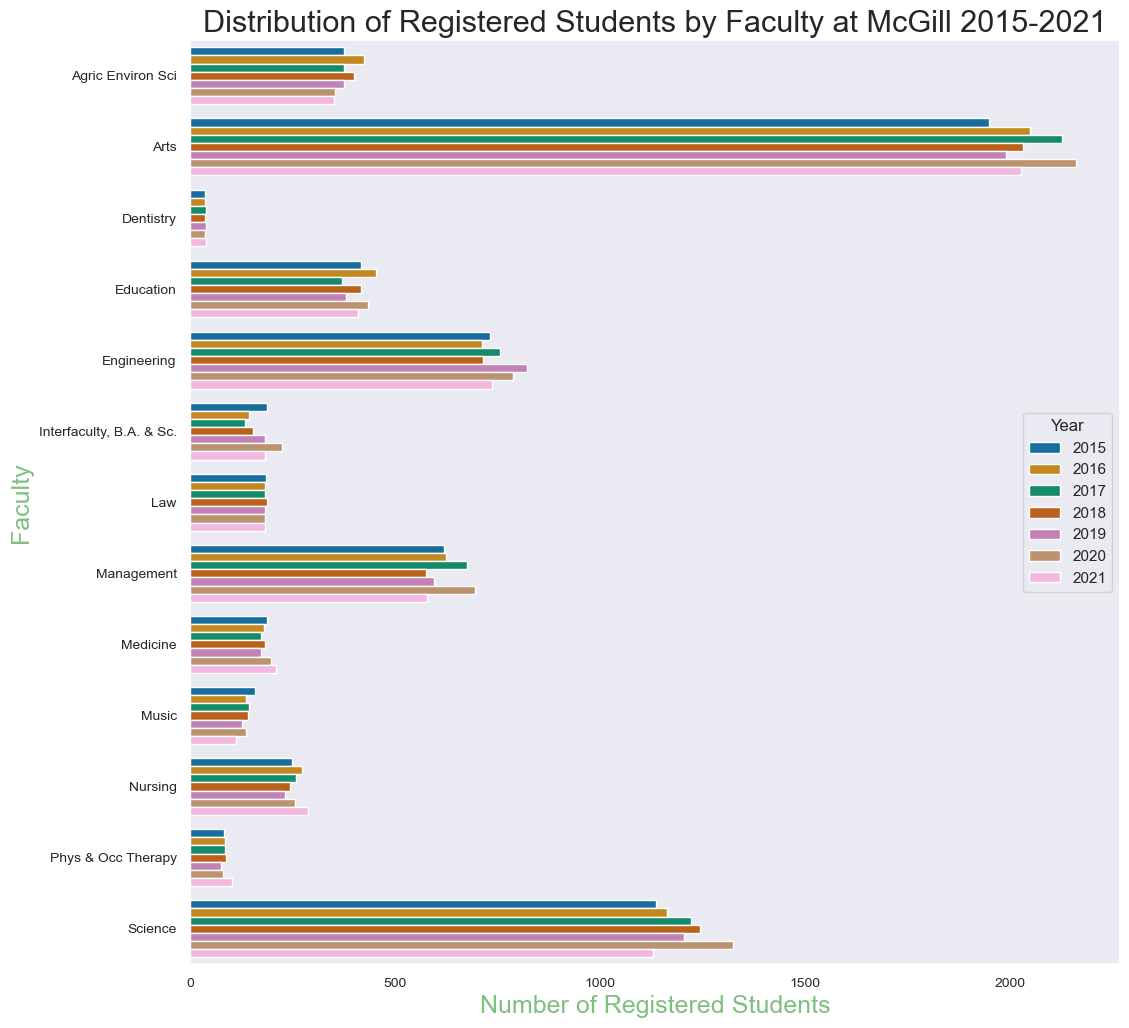

In [34]:
fig1, ax1 = plt.subplots(figsize = (12,12))
sns.barplot(ax = ax1, data = by_field_1_field, y='Undergrade', x='Registered Students', hue='Year', orient = 'h', palette = 'colorblind')

ax1.set_xlabel('Number of Registered Students', fontsize = 18, color = 'green', alpha = 0.5)
ax1.set_ylabel('Faculty', fontsize=18, color = 'green', alpha = 0.5)
plt.xticks(fontsize = 10)
plt.yticks(fontsize =10)
ax1.set_title ('Distribution of Registered Students by Faculty at McGill 2015-2021', fontsize=22)
ax1.legend (loc = 5, title = 'Year');

Since there are too many information in the chart above, 
I decided to draw a piechart with the mean of registered students for each field

In [35]:
# Summary Generation
sum_mean_field = by_field_1_field.groupby('Undergrade')['Registered Students'].mean()
sum_mean_field_df = pd.DataFrame(sum_mean_field).reset_index()
sum_mean_field_df.sort_values(by='Registered Students', ascending = False)

# Too many cats, try joining - I know R has such a thing to join but did not find in Python
# - Arts, Science, Engineering, Management, Edu, Agri - single grouped 6
# - Dentistry 3, Medicine 8, Therapy 11, Nursing 10 - Medicine Grouped - 4
# - Law 6, Music 9, Interfaculty 5 - Others

# Medicine Grouped
sum_mean_field_df.loc[14] = sum_mean_field_df.iloc[[2,8,11,10]].sum()
sum_mean_field_df.iloc[13,0] = 'Grouped Medicine'

# Others
sum_mean_field_df.loc[15] = sum_mean_field_df.iloc[[5,6,9]].sum()
sum_mean_field_df
sum_mean_field_df.iloc[14,0] = 'Others'

# Drop Data
sum_mean_field_df.drop(sum_mean_field_df.index[[2,8,11,10,5,6,9]], inplace = True)

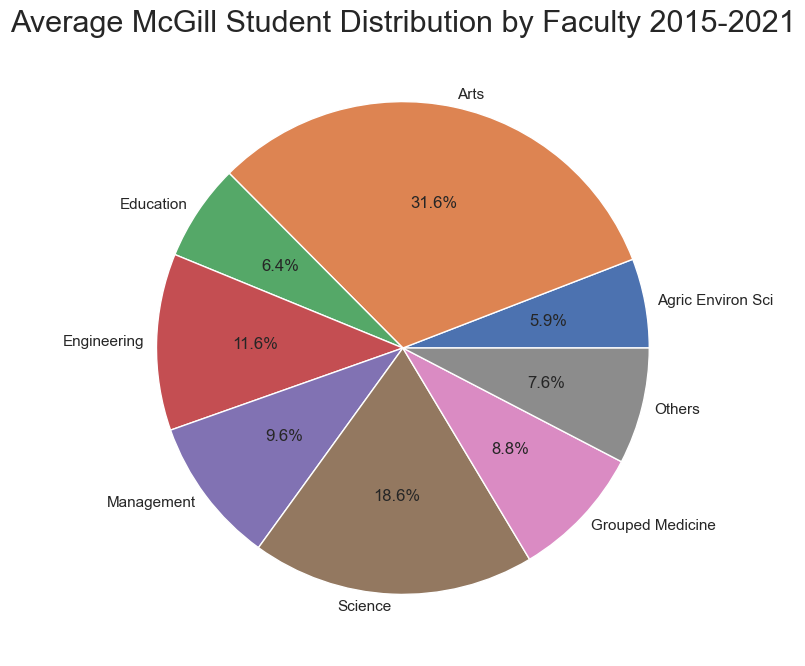

In [36]:
fig2, ax2 = plt.subplots(figsize = (8,8))
ax2.pie(sum_mean_field_df['Registered Students'], labels = sum_mean_field_df['Undergrade'], autopct='%1.1f%%', labeldistance=1.05)

ax2.set_title('Average McGill Student Distribution by Faculty 2015-2021', fontsize = 22);


#### Total student change by time - applicants vs registered

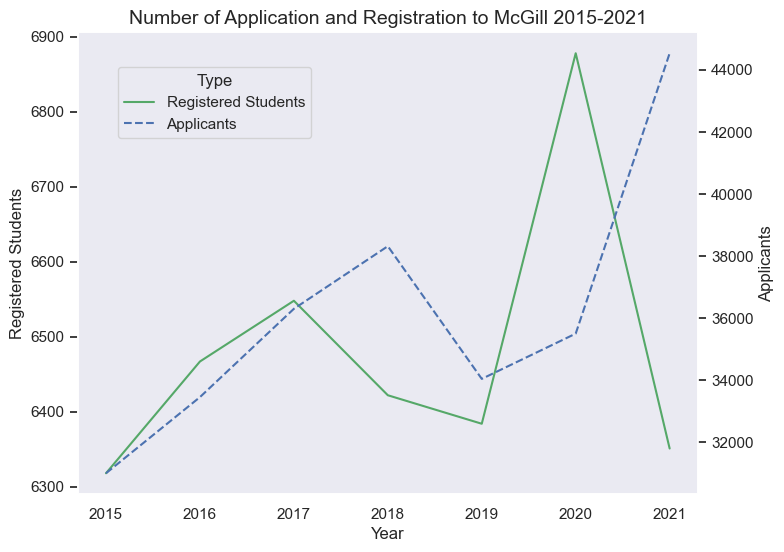

In [37]:
#Visualization
fig3, ax3 = plt.subplots(figsize = (8,6))

sns.lineplot(ax = ax3, data = by_field_1_total, x = 'Year_cat', y = 'Registered Students',\
              color = 'g', label = 'Registered Students', legend=False)

ax3_t = ax3.twinx()
sns.lineplot(ax = ax3_t, data = by_field_1_total, x = 'Year_cat', y = 'Applicants', \
             color = 'b', label = 'Applicants', linestyle = '--', legend = False)

fig3.legend(loc = (0.15,0.75), title = 'Type', fancybox = True)
ax3.set_xlabel('Year')
plt.title('Number of Application and Registration to McGill 2015-2021', fontsize = 14);

Typically, the trend of number of application and registration overlaps, except for 2018, 2020, 2021, especially for the year 2020 and 2021

The next step is to find which faculty takes in more students and which faculty takes fewer and probably the underlying reason.

**I will proceed to analyze the biggest change that happens in 2021, a almost 10k increase in applicants.**

In [38]:
# Filter out the data
fluctuation_19 = by_field_1_field[(by_field_1_field['Year'] >=2019) &(by_field_1_field['Year'] <=2021)]

#.copy() -> This is to avoid a warning since sometimes a view instead of a copy of the original dataframe can be issued
full_fluc = fluctuation_19.sort_values(by=['Undergrade', 'Year']).copy()

In [39]:
# Shift the data + find rate
full_fluc['Pre_App'] = full_fluc['Applicants'].shift(1)
full_fluc['App_diff'] = (full_fluc['Applicants'] - full_fluc['Pre_App'])
full_fluc['Pre_Reg'] = full_fluc['Registered Students'].shift(1)
full_fluc['Reg_diff'] = (full_fluc['Registered Students'] - full_fluc['Pre_Reg'])

# Drop the 2019 data because it is not plotted
full_fluc.drop(full_fluc[full_fluc['Year'] == 2019].index, inplace = True)

In [40]:
# Find the major change in 2021
full_fluc[full_fluc['Year'] == 2021].sort_values(by = 'App_diff').tail(3)[['Undergrade','Year', 'App_diff']]
# That should explain the difference                                                              

,Undergrade,Year,App_diff
85,Management,2021,2167.0
90,Science,2021,2738.0
79,Arts,2021,3406.0


#### Top 3 most difficult field to get in on average

In [41]:
# Build colume
get_in_rate = by_field_1_field.copy()
get_in_rate['Admission Rate %'] = get_in_rate['Registered Students']/get_in_rate['Applicants'] *100
get_in_rate.sort_values('Admission Rate %', inplace = True)

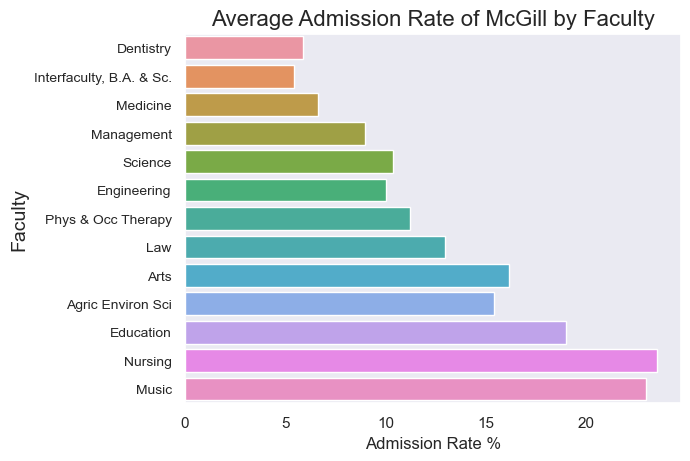

In [42]:
# Visualization
# print(sns.__version__)
fig4, ax4 = plt.subplots()

sns.barplot(ax = ax4, data = get_in_rate, x = 'Admission Rate %', y = 'Undergrade', orient ='h', ci=None); # ci= For version 0.11.2
ax4.set_ylabel('Faculty', fontsize = 14)
ax4.set_title('Average Admission Rate of McGill by Faculty', fontsize = 16)
plt.yticks(fontsize =10);

Congratulations for those who got into the faculty of **Dentistry**, **Interfaculty B.A. & Sc.**, and **Medicine**! 

And to myself for completeing the first half of the project 1 :)


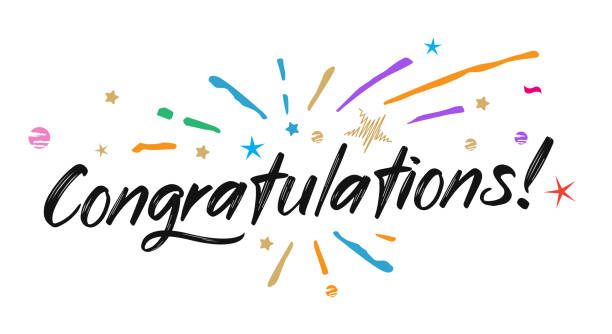

### By Region

`by_region_1` is the clean dataset used in data anlysis and data visualization. 

Note that when doing this part of analysis, given that from 2020-2021 there was a huge increase in applicant number, checking the application distribution by region may be a good idea. However, it is not provided on the official website. 


There is barely fluctuation in Registered Students Number, analyzing the registered students number flucuation by region would not be as exciting. 

Questions to answer
1. Fluctuation in student number from different region undergrade only to compare with the pattern of registered students above - Line chart, 3 lines, drop Not reported
2. Average region distribution of Undergrade, Continuing Education and Graduate - piechart, 3 grids

In [43]:
# Data split up to total and field
by_region_1_total = by_region_1[by_region_1['Region'] == 'Total'].reset_index(drop=True)
print(len(by_region_1_total))
by_region_1_region = by_region_1[-(by_region_1['Region'] == 'Total')].reset_index(drop=True)
print(len(by_region_1_region))

7
35


#### Fluctuation in student number from different region undergrade only

In [44]:

diff_reg = by_region_1_region[-(by_region_1_region['Region']=='-Not reported')]

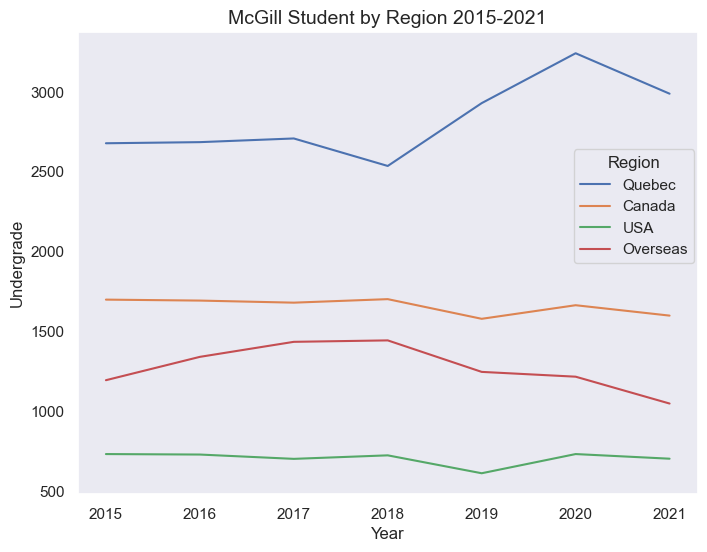

In [45]:
# Visualization
fig5, ax5 = plt.subplots(figsize = (8,6))

sns.lineplot(ax = ax5, data=diff_reg , x='Year_cat', y = 'Undergrade', hue = 'Region')

plt.annotate('Me entering McGill', (2018,1450), 
             ha = 'center', textcoords = 'offset points', xytext=(0, -30), 
             arrowprops=dict(arrowstyle="->", color='red'))
plt.title('McGill Student by Region 2015-2021', fontsize = 14)
plt.xlabel('Year')
plt.legend(loc=(0.8,0.5), title = 'Region', fancybox = True);


There are always way more local Quebec students than students from other regions at McGill!

#### Average region distribution of Undergrade, Continuing Education and Graduate

In [46]:

# Select out the needed columns
reg_amg_3 = by_region_1_region[['Region', 'Year','Undergrade', 'Continuing Education', 'Graduate']][-(by_region_1_region['Region']=='-Not reported')]

#Create Summary
sum_reg = reg_amg_3.groupby('Region').mean().apply(lambda x : round(x,2)).reset_index()
sum_reg

,Region,Year,Undergrade,Continuing Education,Graduate
0,Canada,2018.0,1661.43,47.00,516.29
1,Overseas,2018.0,1277.43,275.29,718.00
2,Quebec,2018.0,2824.57,415.14,1165.00
3,USA,2018.0,707.86,21.71,203.71


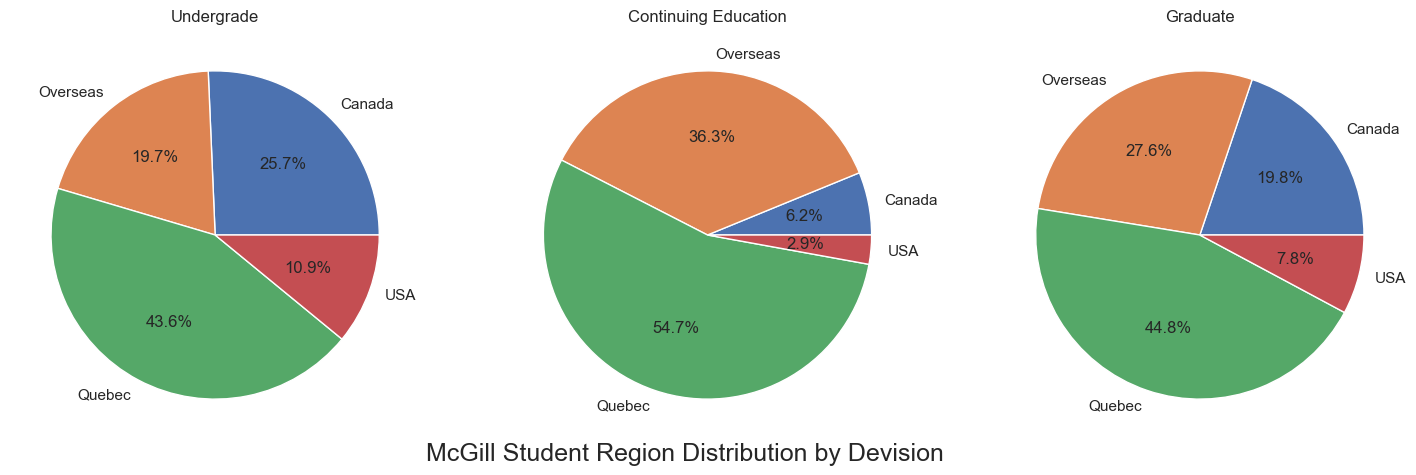

In [47]:
# visualization
# Could have used a loop

fig6, (ax6a, ax6b, ax6c) = plt.subplots(nrows=1, ncols=3, figsize = (18,6))

# Undergrade
ax6a.pie( x=sum_reg['Undergrade'], labels = sum_reg['Region'], autopct='%1.1f%%')
ax6a.set_title('Undergrade')

# Continuing Education
ax6b.pie( x=sum_reg['Continuing Education'], labels = sum_reg['Region'], autopct='%1.1f%%')
ax6b.set_title('Continuing Education')

# Graduate
ax6c.pie( x=sum_reg['Graduate'], labels = sum_reg['Region'], autopct='%1.1f%%')
ax6c.set_title('Graduate')

fig6.suptitle('McGill Student Region Distribution by Devision', fontsize = 18, y = 0.15);

The pattern aligns with my expecatation: there are always more Quebec students than others. However, in the sector of continuing education, international students and Qubecois takes most of the population at McGill. More Canadians and fewer internationals students was expected.

# End + Future Step

This will end my project 1. Thank you for reading. It was not a huge project but challenging for some parts. ChatGPT indeed gave me a lot of guidance as well as the documentations of seaborn and matplotlib. 

The future potential continuation of the project can be the following:
1. Combine data from other years by modifying `get_table()` to get a thorough analysis
2. Find a way to automatically update data for upcoming years
3. Find region distribution in each faculty

In [52]:
by_field_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98 entries, 0 to 98
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Undergrade           98 non-null     object
 1   Applicants           98 non-null     int64 
 2   Registered Students  98 non-null     int64 
 3   Year                 98 non-null     int64 
 4   Year_cat             98 non-null     object
dtypes: int64(3), object(2)
memory usage: 4.6+ KB
